## Import Library

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pemisahan Dataset dan Augmentasi Data



In [3]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

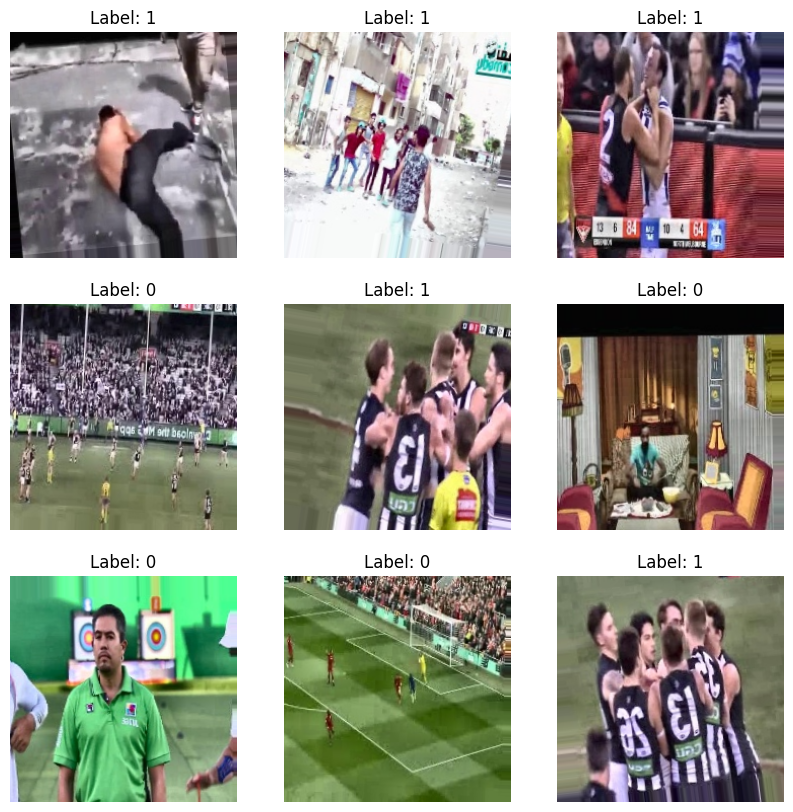

In [4]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [5]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_NoFreeze_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 15,110,465 (57.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5158 - loss: 1.4026
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to MCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 725s 14s/step - accuracy: 0.5161 - loss: 1.4008 - val_accuracy: 0.5000 - val_loss: 36.7141
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.5636 - loss: 1.0685
Epoch 2: val_accuracy did not improve from 0.50000
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 683ms/step - accuracy: 0.5633 - loss: 1.0687 - val_accuracy: 0.5000 - val_loss: 23.4548
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6031 - loss: 0.9751
Epoch 3: val_accuracy improved from 0.50000 to 0.50682, saving model to MCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 685ms/step - accuracy: 0.6030 - loss: 0.9753 - val_accuracy: 0.5068 - val_loss: 1.5471
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.5713 - loss: 0.9628
Epoch 4: val_accuracy did not improve from 0.50682
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 678ms/step - accuracy: 0.5717 - loss: 0.9623 - val_accuracy: 0.5000 - val_loss: 202.6240
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6271 - loss: 0.8689
Epoch 5: val_accuracy did not improve from 0.50682
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 670ms/step - accuracy: 0.6271 - loss: 0.8686 - val_accuracy: 0.5000 - val_loss: 685.0848
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6831 - loss: 0.7691
Epoch 6: val_accuracy did not improve from 0.50682
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 691ms/step - accuracy: 0.6831 - loss: 0.7691 - val_accuracy: 0.5000 - val_loss: 3.1315
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6631 - loss: 0.7921
Epoch 7: val_accuracy did n

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 690ms/step - accuracy: 0.6442 - loss: 0.7474 - val_accuracy: 0.5545 - val_loss: 1.2660
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7350 - loss: 0.6262
Epoch 10: val_accuracy did not improve from 0.55455
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step - accuracy: 0.7350 - loss: 0.6263 - val_accuracy: 0.5000 - val_loss: 1.5925
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.7178 - loss: 0.6516
Epoch 11: val_accuracy did not improve from 0.55455
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.7179 - loss: 0.6511 - val_accuracy: 0.5000 - val_loss: 2.9711
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7456 - loss: 0.6156
Epoch 12: val_accuracy did not improve from 0.55455
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 694ms/step - accuracy: 0.7457 - loss: 0.6151 - val_accuracy: 0.5250 - val_loss: 2.3634
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.7679 - loss: 0.5725
Epoch 13: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 699ms/step - accuracy: 0.7892 - loss: 0.5408 - val_accuracy: 0.6500 - val_loss: 0.8419
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7761 - loss: 0.5362
Epoch 16: val_accuracy did not improve from 0.65000
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 683ms/step - accuracy: 0.7762 - loss: 0.5361 - val_accuracy: 0.5000 - val_loss: 2.1366
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7813 - loss: 0.5275
Epoch 17: val_accuracy improved from 0.65000 to 0.77273, saving model to MCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 689ms/step - accuracy: 0.7812 - loss: 0.5277 - val_accuracy: 0.7727 - val_loss: 0.5236
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.7952 - loss: 0.5131
Epoch 18: val_accuracy did not improve from 0.77273
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 680ms/step - accuracy: 0.7950 - loss: 0.5133 - val_accuracy: 0.5909 - val_loss: 0.9248
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7910 - loss: 0.5088
Epoch 19: val_accuracy did not improve from 0.77273
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 675ms/step - accuracy: 0.7912 - loss: 0.5089 - val_accuracy: 0.5182 - val_loss: 1.1436
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7990 - loss: 0.5332
Epoch 20: val_accuracy did not improve from 0.77273
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.7989 - loss: 0.5329 - val_accuracy: 0.5045 - val_loss: 1.6528
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8243 - loss: 0.4548
Epoch 21: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 704ms/step - accuracy: 0.8041 - loss: 0.4831 - val_accuracy: 0.7909 - val_loss: 0.4652
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.8038 - loss: 0.4920
Epoch 23: val_accuracy did not improve from 0.79091
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.8038 - loss: 0.4919 - val_accuracy: 0.6205 - val_loss: 0.9878
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8034 - loss: 0.4786
Epoch 24: val_accuracy did not improve from 0.79091
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 689ms/step - accuracy: 0.8036 - loss: 0.4786 - val_accuracy: 0.5864 - val_loss: 1.3886
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8149 - loss: 0.4440
Epoch 25: val_accuracy did not improve from 0.79091
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 703ms/step - accuracy: 0.8150 - loss: 0.4442 - val_accuracy: 0.7886 - val_loss: 0.5879
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8054 - loss: 0.4862
Epoch 26: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 691ms/step - accuracy: 0.8441 - loss: 0.4055 - val_accuracy: 0.8341 - val_loss: 0.4179
Epoch 33/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8458 - loss: 0.4049
Epoch 33: val_accuracy did not improve from 0.83409
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 679ms/step - accuracy: 0.8459 - loss: 0.4047 - val_accuracy: 0.5682 - val_loss: 0.8448
Epoch 34/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.8687 - loss: 0.3703
Epoch 34: val_accuracy did not improve from 0.83409
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 678ms/step - accuracy: 0.8687 - loss: 0.3704 - val_accuracy: 0.8227 - val_loss: 0.4187
Epoch 35/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8431 - loss: 0.4080
Epoch 35: val_accuracy did not improve from 0.83409
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.8434 - loss: 0.4072 - val_accuracy: 0.5000 - val_loss: 2.4508
Epoch 36/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8831 - loss: 0.3467
Epoch 36: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 690ms/step - accuracy: 0.8830 - loss: 0.3155 - val_accuracy: 0.8455 - val_loss: 0.3609
Epoch 42/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.8743 - loss: 0.3392
Epoch 42: val_accuracy did not improve from 0.84545
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 677ms/step - accuracy: 0.8746 - loss: 0.3388 - val_accuracy: 0.6614 - val_loss: 0.9498
Epoch 43/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.8831 - loss: 0.3383
Epoch 43: val_accuracy improved from 0.84545 to 0.87045, saving model to MCLAHE_NoFreeze_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 692ms/step - accuracy: 0.8832 - loss: 0.3380 - val_accuracy: 0.8705 - val_loss: 0.2992
Epoch 44/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8782 - loss: 0.3139
Epoch 44: val_accuracy did not improve from 0.87045
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 675ms/step - accuracy: 0.8783 - loss: 0.3140 - val_accuracy: 0.7886 - val_loss: 0.6234
Epoch 45/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8878 - loss: 0.3059
Epoch 45: val_accuracy did not improve from 0.87045
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 677ms/step - accuracy: 0.8880 - loss: 0.3055 - val_accuracy: 0.8705 - val_loss: 0.3415
Epoch 46/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8930 - loss: 0.2890
Epoch 46: val_accuracy did not improve from 0.87045
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 680ms/step - accuracy: 0.8927 - loss: 0.2896 - val_accuracy: 0.8386 - val_loss: 0.3860
Epoch 47/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.8885 - loss: 0.3060
Epoch 47: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 702ms/step - accuracy: 0.8915 - loss: 0.2751 - val_accuracy: 0.8841 - val_loss: 0.3094
Epoch 50/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8889 - loss: 0.2739
Epoch 50: val_accuracy did not improve from 0.88409
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 681ms/step - accuracy: 0.8890 - loss: 0.2737 - val_accuracy: 0.5182 - val_loss: 2.2895


## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.8089 - loss: 0.9185
Validation Loss: 2.28950834274292
Validation Accuracy: 0.5181818008422852


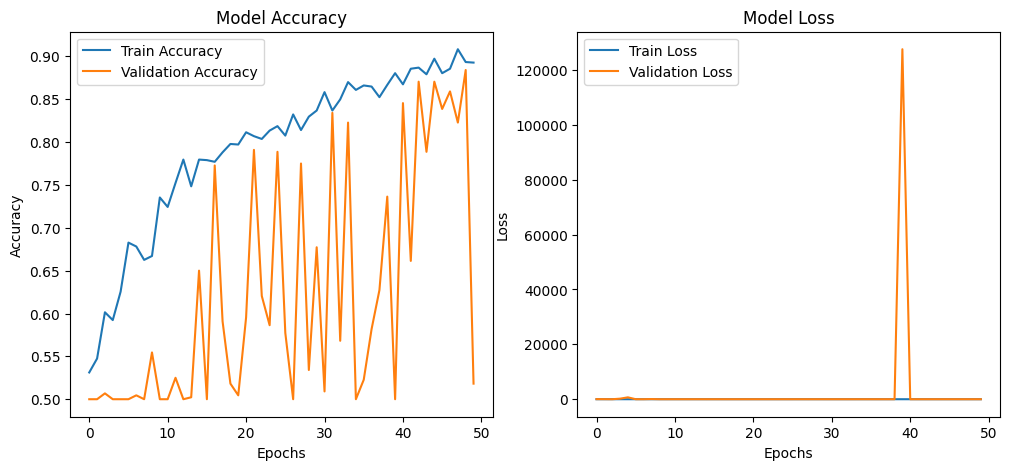

In [7]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [8]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_NoFreeze_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 12s/step - accuracy: 0.8777 - loss: 0.3642
Test Accuracy : 89.64%
Test Loss     : 0.298


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step


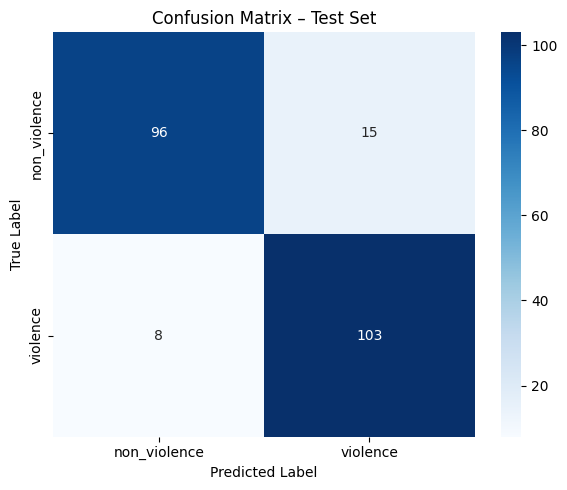


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.92      0.86      0.89       111
    violence       0.87      0.93      0.90       111

    accuracy                           0.90       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.90      0.90      0.90       222



In [9]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))